## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date']=pd.to_datetime(data['date'], dayfirst=True)
data_group_start=data.groupby('group')['date'].min()
data_group_finish=data.groupby('group')['date'].max()
print(data_group_start)
print(data_group_finish)

group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]
group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
#Количество посещений сайта в группах А и В
data_group_count=data.groupby('group')['user_id'].count()
print("Количество посещений сайта в группe А: {}".format(data_group_count[0]))
print("Количество посещений сайта в группe B: {}".format(data_group_count[1]))

# Количество суммарное покупок в группе А и В
data_group_purchase=data.groupby('group')['purchase'].sum()
print("Суммарное количество покупок в группе А: {}".format(data_group_purchase[0]))
print("Суммарное количество покупок в группе B: {}".format(data_group_purchase[1]))


#Сумма всех покупок в группах А и В
data_group_price=data.groupby('group')['price'].sum()/1000000
print("Сумма всех покупок в группах А: {} млн.руб.".format(data_group_price[0]))
print("Сумма всех покупок в группах B: {} млн.руб.".format(data_group_price[1]))

Количество посещений сайта в группe А: 147202
Количество посещений сайта в группe B: 147276
Суммарное количество покупок в группе А: 17723
Суммарное количество покупок в группе B: 17514
Сумма всех покупок в группах А: 1436.26 млн.руб.
Сумма всех покупок в группах B: 1554.1 млн.руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
a_set=set(data[data['group']=='A']['user_id'])
b_set=set(data[data['group']=='B']['user_id'])
user_intersection=a_set.intersection(b_set)
print(len(user_intersection))


1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

![image.png][def]
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


[def]: attachment:95f235d2-6323-4799-bf69-697fc57f727b.png

In [8]:
data_group_7_5=updated_data.groupby('group').agg({'user_id':'count', 
                                          'purchase':'sum', 
                                          'price':'sum'}
                                    ).rename(columns={"user_id": "count_visits", 
                                          "purchase": "count_purchases", 
                                          "price":"sum_price"})
data_group_7_5

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Мы знаем, что сопоставимость наблюдений в обоих вариантах чрезвычайно важна. Из полученных данных видно, что разница в количестве посещений  составляет  74  посещения  или  0,05%, считаю, что можно говорить о сопоставимости количества посещений в обеих группах.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
# Конверсия покупки
data_group_7_5['conversion']=round(data_group_7_5['count_purchases']/data_group_7_5['count_visits']*100, 2)

#Средний чек покупки
data_group_7_5['mean_check']=round(data_group_7_5['sum_price']/data_group_7_5['count_purchases'])

print('Конверсия в группе А: {}'.format(data_group_7_5['conversion'][0]))
print('Конверсия в группе B: {}'.format(data_group_7_5['conversion'][1]))
print('Средний чек в группе А: {}'.format(data_group_7_5['mean_check'][0]))
print('Средний чек в группе В: {}'.format(data_group_7_5['mean_check'][1]))
data_group_7_5

Конверсия в группе А: 12.03
Конверсия в группе B: 11.89
Средний чек в группе А: 81076.0
Средний чек в группе В: 88665.0


,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Из полученных данных видно, что в группе А конверсия покупки несколько выше, чем в групппе В, в то время как в группе В выше средний чек покупки. Поскольку Компания запланировала не просто увеличить прибыль, а увеличить именно число продаж туров, то можно подумать, что вариант А справляется с задачей лучше, однако прежде чем делать выводы нужно оценить является ли имеющаяся разница в показателе конверсии значительной, или все таки получение дополнительной прибыли для бизнеса станет более весомым аргументом при выборе варианта посадочной страницы.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
data_7_7=round(updated_data.groupby(['price', 'group'], as_index=False)['purchase'].sum())
data_7_7=updated_data.pivot_table(values='purchase',
                            index='group',
                            columns='price',
                            aggfunc='sum',
                            fill_value=0)
data_7_7

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [11]:
import plotly.express  as  px
fig=px.imshow(data_7_7)
fig.show()
fig.write_html('map1.html')

In [12]:
# Дополнительное исследование, которое показывает сколько продаж туров приходится посетителей сайта, которых удалили по причине того, что они попали сразу в 2 группы
print('Количество покупок посетителей, попавших в обе группы: {}'.format(data['purchase'].sum()-updated_data['purchase'].sum()))

Количество покупок посетителей, попавших в обе группы: 460


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Тепловая карта очень наглядно иллюстрирует варианты покупательной способности в группах. Так у участников групы А выше покупательная способность по предлагаемым турам в Турцию, а у участников группы В в Тайланд.

В одном из предыдущих заданий было выявленно, что в группе А несколько выше конверсия покупки туров, зато в группе В выше средний чек. Теперь, с помощью данной тепловой карты мы видим, что больший средний чек во второй группе присутствует из-за того, что куплено почти в 3 раза больше туров в Тайланд. Мы не видели как именно выглядит посадочная страница варианта А и варианта В, но стоит обратить внимание на то как представлены туры в Тайланд, возможно на странице В они выглядят более привлекательно (более позитивные фото/видео) это следует учесть при принятии итогового решения. 



## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [14]:
data_group_7_8 = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
data_group_7_8['conversion'] = data_group_7_8['count_purchases']/data_group_7_8['count_visits'] * 100
data_group_7_8['mean_check'] = data_group_7_8['sum_price']/data_group_7_8['count_purchases']

print('Конверсия 3 января 2020 года:')
display(data_group_7_8[data_group_7_8['date'] == pd.to_datetime('2021-01-03')][['group', 'conversion']].round(2))
 
print('Средний чек 3 января 2020 года:')
display(data_group_7_8[data_group_7_8['date'] == pd.to_datetime('2021-01-03')][['group', 'mean_check']].round())


Конверсия 3 января 2020 года:


,group,conversion
2,A,11.34
3,B,11.39


Средний чек 3 января 2020 года:


,group,mean_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [ ]:

# вычисляем кумулятивную сумму количества посетителей
data_group_7_8['cum_users_count'] = data_group_7_8.groupby('group')['count_visits'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
data_group_7_8['cum_purchase_sum'] = data_group_7_8.groupby('group')['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
data_group_7_8['cum_price_sum'] = data_group_7_8.groupby('group')['sum_price'].cumsum()
#Кумулятивная конверсия
data_group_7_8['cum_conversies']=round(data_group_7_8['cum_purchase_sum']/data_group_7_8['cum_users_count']*100, 2)
#Кумулятивный средний чек
data_group_7_8['cum_average_check']=round(data_group_7_8['cum_price_sum']/data_group_7_8['cum_purchase_sum'])


print('Кумулятивная конверсия 20 января 2020 года:')
display(data_group_7_8[data_group_7_8['date'] == pd.to_datetime('2021-01-20')][['group', 'cum_conversies']].round(2))
print('Кумулятивная конверсия 12 января 2020 года:')
display(data_group_7_8[data_group_7_8['date'] == pd.to_datetime('2021-01-12')][['group', 'cum_average_check']].round())
 

Кумулятивная конверсия 20 января 2020 года:


,group,cum_conversies
36,A,11.98
37,B,11.90


Кумулятивная конверсия 12 января 2020 года:


,group,cum_average_check
20,A,81492.0
21,B,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

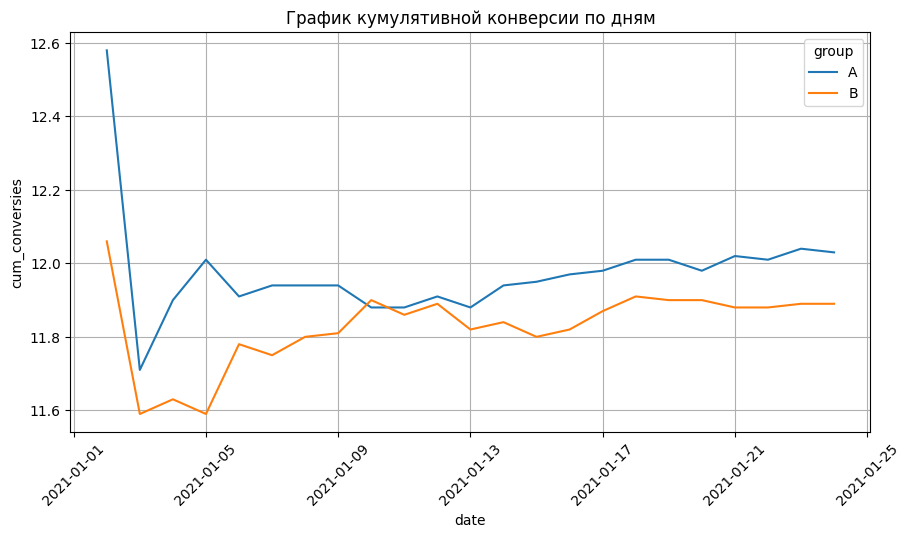

In [ ]:
#fig = plt.figure(figsize=(8, 4))
#ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
#sns.lineplot(x='date', y='cum_conversies', data=data_group_7_8, hue='group', ax=ax)
# задаём подпись к графику
#ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
#ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
#ax.grid(True);

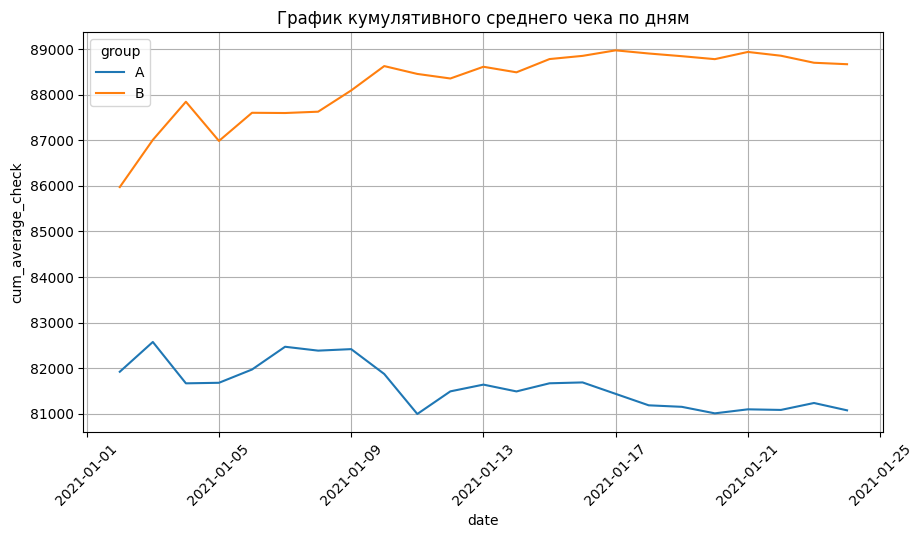

In [ ]:
#fig = plt.figure(figsize=(8, 4))
#ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
#sns.lineplot(x='date', y='cum_average_check', data=data_group_7_8, hue='group', ax=ax)
# задаём подпись к графику
#ax.set_title('График кумулятивного среднего чека по дням')
## задаём поворот меток на оси абсцисс
#ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
#ax.grid(True);

Значение метрик во времени стабилизировались, а значит можно считать А/В-тест завершенным. На графиках отчетливо видно подтверждении ранее отмеченного поведения метрик, а именно: конверсия в группе А незначительно выше, Прибыль в группе В существенно выше.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
purchases_piv= updated_data.groupby('group')['purchase'].agg(['sum', 'count'])
purchases_piv

,sum,count
group,,
A,17487,145307
B,17290,145381


In [ ]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=purchases_piv['sum'], #число "успехов"
    nobs=purchases_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

 Z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), следовательно полученная разница в метрике в группах статистически не значима.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

#Расчет доверительного интервала для конверсий
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), 
x_p=a_data['purchase'].mean())

conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), 
x_p=b_data['purchase'].mean())

# Расчет доверительного интервала для разницы конверсий
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma 
    diff = xp[1] - xp[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [a_data['user_id'].count(), b_data['user_id'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
diff_inverval = diff_proportions_conf_interval(n, xp)

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))


Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

После нахождения доверительных интервалов стало видно, что присутствует пересечение интервалов. Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть. То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Поэтому рассомтрим доверительный интервал разности конверсий. Доверительный интервал для разности конверсий лежит между -0.39 и 0.09, то есть охватывает 0. Таким образом можно сказать, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
from scipy.stats import shapiro

H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result = shapiro(data_group_7_8['mean_check'])

print('p-value', round(shapiro_result.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if shapiro_result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value 0.35
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
 
daily_data_a = data_group_7_8[data_group_7_8['group'] == 'A']
daily_data_b = data_group_7_8[data_group_7_8['group'] == 'B']
 
#вычисляем результат T-теста для выборок
results = ttest_ind(
    daily_data_a['mean_check'],
    daily_data_b['mean_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


Т-тест подтвердил данные, полученные ранее, что средний чек в группе А меньше чем в группе В.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
a_daily_data = daily_data[daily_data['group'] == 'A']
b_daily_data = daily_data[daily_data['group'] == 'B']
 
params_a = {
    'n': a_daily_data['count_visits'].count(), # размер выборки
    'x_mean': a_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': a_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': b_daily_data['count_visits'].count(),# размер выборки
    'x_mean': b_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': b_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

In [ ]:
n = daily_data_a['count_visits'].count() 
k = n - 1 
x_mean = daily_data_a['mean_check'].mean() 
x_std = daily_data_a['mean_check'].std() 
gamma = 0.95 
alpha = 1 - gamma 
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) 
eps = t_crit * x_std/(n ** 0.5)
lower_bound = x_mean - eps 
upper_bound = x_mean + eps 
confidence_interval = (round(lower_bound), round(upper_bound)) 

print('Доверительный интервал в группе А: {}'.format(confidence_interval)) 

n = daily_data_b['count_visits'].count() 
k = n - 1 
x_mean = daily_data_b['mean_check'].mean() 
x_std = daily_data_b['mean_check'].std() 
gamma = 0.95 
alpha = 1 - gamma 
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) 
eps = t_crit * x_std/(n ** 0.5)
lower_bound = x_mean - eps 
upper_bound = x_mean + eps 
confidence_interval = (round(lower_bound), round(upper_bound)) 
print('Доверительный интервал в группе B: {}'.format(confidence_interval)) 

Доверительный интервал в группе А: (79630, 82308)
Доверительный интервал в группе B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительные интервалы не пересекаются, вероятнее всего истинное значение среднего чека в группе А лежит в интервале от 79630 до 82308, истинное значение среднего чека в группе В - от 87626 до 89526.

Итак, для того, чтобы правильно интерпретировать результаты А/В тестирования, и оценить на сколько применение варианта А или варианта В способно решить поставленную задачу, вернемся к цели, которую ставила перед собой компания. А звучала она так: "Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта...". То есть цель - продать как можно больше туров. Но оценить эффективность каждого варианта предполагалось не только по конверсии, но и по размеру среднего чека.

По итогам всех манипуляций с данными, как говориться "в сухом остатке" мы имеем: конверсии в обоих группах одинаковые, средний чек выше в группе В. К каким выводам нас это подводит?

 Изначально мы рассмотривали туры, предусматривающие три вида отдыха: Санкт-Петербург - городской отдых в культурной среде с посещением достопримечательностей, Камчатка - отдых для любителей красоты и величия уникальной природы этого края, Турция, Тайланд, Мальдивы - пляжный отдых. Большинство тех, кто заходит на сайт тур-оператора заранее определились с видом отдыха и рассмотривают варианты уже внутри одного их этих трех направлений. То, что по направлению "пляжный отдых" Мальдивы рассматривают люди, готовые к существенным тратам на путешествие, может означать, что компании слолжно предложить им достаточно "дорогой" (выгодный, привлекательный) акционный кейс. Поэтому на приобрешение туров по направлению Мальдивы акции, предлагаемые компанией не влияют (продажи в обоих группах сопоставимы). Туры на Камчатку и в Санкт-Петербург являются уникальными в своих направлениях. Например Камчатке можно предпочесть Байкал или Карелию, но не Тайланд, а Санкт-Петербургу - Москву, Казань или Нижний Новгород, но не Турцию (продажи в обоих группах по этим направлениям также сопоставимы). Таким образом мы подходим к тому, что предоставлением акционных кейсов можно стимуллировать покупательную способность на относительно бюджетный отдых у моря. 

 Поэтому мой совет компании, доработать дизайн посадочной страницы именно с акцентом на направления Турция, Тайланд.

 Пару слов о том, почему при наличии более высокого среднего чека в группе В, я не советую однозначно принимать этот вариант дизайна, как единственно предпочтительный. Мы выяснили, что средний чек в группе В выше за счет большего числа покупки туров в Тайланд. Следует учесть, что на некоторых курортах Тайланда очень продолжительный сезон дождей, и естественным образом это обстоятельство снизит спрос на туры в Тайланд на этот период. Именно поэтому дизайн, который имеет преимущества по чеку только за счет туров в Тайланд не обеспечит высокий чек на долгосрочную перспективу.
 
 Не могу не отметить, что данная работа не предполагает анализ тех посетителей сайта, которые были вначале исключены из данных, по причине того, что пользовались и А и В версией, то есть попали в обе группы. Возможно, если посмотреть как вели себя пользователи которые имели возможность сравнить два варианта, то можно было бы сделать предположения на тему сниженного спроса на туры в Турцию в группе В и проработать конкретно это направление, тем более что из 1895 исключенных пользователей 460 все таки совершили покупки. 

 Учитывая, что при постановке задачи по увеличению продажи туров, речь шла о том, что компания планирует запустить новую акцию. Мы не знаем, какая это акция, но понимаем, что акции бывают очень разными от бесплатной расширенной страховки, бесплатного трансфера до скидок на товары компаний-партнеров, поэтому возможно компании стоит пересмотреть само содержание акции. Главное, на отдыхе люди хотят отдыхать, а не решать проблемы, поэтому та компания, которая предложит наиболее эффективное решение всех возможных трудностей, та и получит клиента, а это и конверсия и высокий чек.


## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 